In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from tdwg.lib.io_utils import *
from scaling_lib.deltaN import *
from scipy.integrate import complex_ode, odeint
import scaling_lib.ftutils_np as ftutils

In [2]:
from scaling_lib.mode_solver import solve_modes
from scaling_lib.misc_helpers import smoothen_waveguide

# Solve for modes

In [3]:
λ0 = 1.55 #um
ncore = 1.8
nclad = 1.7 #a very shallow partial etch that gives 0.05 deltaN - which I think is about a 100nm partial etch, which can be done descently accurately...
dn_wg = ncore-nclad

d_singlemode = λ0/2/np.sqrt(ncore**2-nclad**2)
k0 = 2*np.pi/λ0

Nmodes = 3
d_wg = 1.3*Nmodes #3 #so that it is less than the 2 mode cut-off

In [4]:
Lx = 3.5*d_wg
Nx = 2**7 #Be power of 2 for FFT
dx = 0.1

# x_axis = np.linspace(-Lx/2, Lx/2, Nx)
x_axis = ftutils.ft_t_axis(Nx, dx)
x2ind = lambda x: np.argmin(np.abs(x_axis-x))

In [5]:
dn_wg_slice = np.zeros(Nx)
dn_wg_slice[x2ind(-d_wg/2):x2ind(d_wg/2)] = dn_wg
dn_wg_slice = smoothen_waveguide(x_axis, dn_wg_slice, nclad * k0)

In [6]:
betas, Evecs = solve_modes(x_axis, nclad, k0, dn_wg_slice, Nmodes)
# betas = betas - nclad*k0

In [7]:
fig_height = 1

Text(0.5, 0, '$x$ (um)')

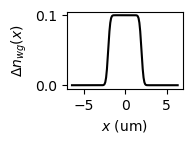

In [8]:
fig, ax = plt.subplots(figsize=(1.5, fig_height))

plt.plot(x_axis, dn_wg_slice, "k")
plt.ylabel(r"$\Delta n_{wg}(x)$")
plt.xlabel(r"$x$ (um)")

Text(0, 0.5, '$E_i(x)$')

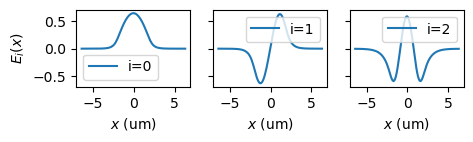

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(5, fig_height), sharey=True)
for (i, ax) in enumerate(axs):
    plt.sca(ax)
    plt.plot(x_axis, np.real(Evecs[i]), label=f"i={i}")
    plt.xlabel(r"$x$ (um)")
    plt.legend()
    
plt.sca(axs[0])
plt.ylabel(r"$E_i(x)$")

# Create refractive index profile

In [10]:
dz = 0.2
Lz = 1e3 #
N_com = 10

Nz = int(round(Lz/dz))
z_axis = (np.arange(Nz)+1)*dz
z2ind = lambda z: np.argmin(np.abs(z_axis-z))

In [11]:
ij_pairs = [(0, 1), (0, 2), (1, 2)]

In [12]:
U = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]]).T 
A = logm(U)/(1j*k0*Lz)

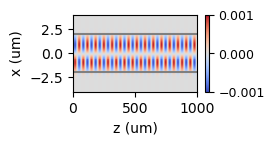

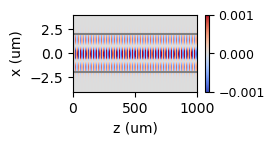

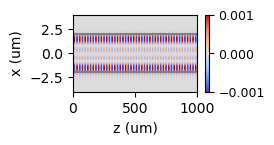

In [13]:
for (ind, (i, j)) in enumerate(ij_pairs):
    deltan = 2*np.imag(A[i,j])*make_deltaN_kl_Im(i, j, Evecs, betas, x_axis, z_axis)

    plt.subplots(figsize=(2,1))
    img = plt.pcolormesh(z_axis, x_axis, deltan.T, cmap="coolwarm", vmax=1e-3, vmin=-1e-3)
    plt.axhline(d_wg/2,  color="gray", linestyle="-")
    plt.axhline(-d_wg/2, color="gray", linestyle="-")
    plt.ylabel("x (um)")
    plt.ylim(-4, 4)
    cbar = plt.colorbar(img)
    cbar.ax.tick_params(labelsize=9)
    plt.xlabel("z (um)")
    plt.xticks([0, 500, 1000]);

In [14]:
dn_prog = make_deltaN(A, Evecs, betas, x_axis, z_axis)

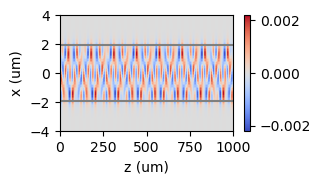

In [15]:
plt.subplots(figsize=(2.8, 1.5))
img = plt.pcolormesh(z_axis, x_axis, np.real(dn_prog.T), cmap="coolwarm")
plt.axhline(d_wg/2,  color="gray", linestyle="-")
plt.axhline(-d_wg/2, color="gray", linestyle="-")
plt.xlabel("z (um)")
plt.ylabel("x (um)")
plt.ylim(-4, 4)
plt.colorbar()
plt.xticks([0, 250, 500, 750, 1000]);

# Simulate beam propagation

In [16]:
from scaling_lib.misc_helpers import E2a, a2atilde
from scaling_lib.simulation_tdwg_repo import WaveguideSimulationWithBackground

In [17]:
wg = WaveguideSimulationWithBackground(nclad, x_axis, z_axis, Ncom = 10)
wg.set_background_delta_n(torch.from_numpy(dn_wg_slice))

In [18]:
E_out = wg.run_simulation_slow(torch.from_numpy(Evecs), torch.from_numpy(dn_prog))

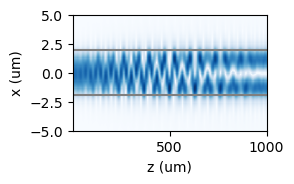

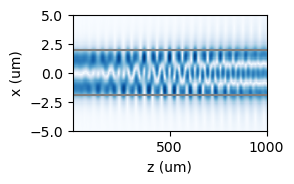

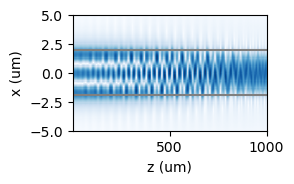

In [19]:
# Do a separate plot

for i in range(3):
    plt.subplots(figsize=(2.5, 1.5))
    img = plt.pcolormesh(wg.z_list, x_axis, torch.abs(wg.Emat_x[:,i]).T, cmap="Blues")
    plt.xlabel("z (um)")
    plt.ylabel("x (um)")
    plt.axhline(d_wg/2,  color="gray", linestyle="-")
    plt.axhline(-d_wg/2, color="gray", linestyle="-")
    plt.ylim(-5, 5)
    # plt.colorbar()

In [25]:
a_list = E2a(wg.Emat_x[:,0].to(torch.cfloat), Evecs, x_axis)
atilde_list = a2atilde(a_list, (betas-nclad*k0), wg.z_list.numpy())

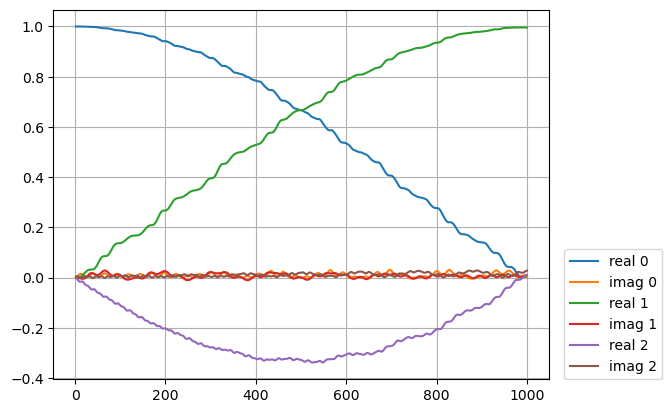

In [26]:
for i in range(Nmodes):
    plt.plot(wg.z_list, np.real(atilde_list[i]), label=f"real {i}")
    plt.plot(wg.z_list, np.imag(atilde_list[i]), label=f"imag {i}")
plt.legend(loc = (1.03, 0.0))
plt.grid()

# Simulate coupled-mode theory with rotating-wave approximation

In [29]:
def da_rot(z, x):
    return 1j*k0*A@x

r = complex_ode(da_rot)
x0 = 0j*np.zeros(Nmodes)
x0[0] = 1.0+0j
# x0[2] = 1.0+0j
r.set_initial_value(x0, 0.0)

output_rot = []

for i in range(Nz):
    output_rot.append(r.integrate(r.t+dz))

output_rot = np.array(output_rot).T

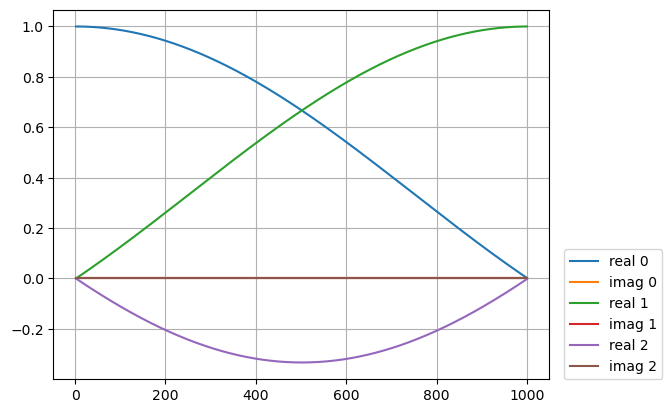

In [30]:
for i in range(Nmodes):
    plt.plot(wg.z_list, np.real(output_rot[i][::10]), label=f"real {i}")
    plt.plot(wg.z_list, np.imag(output_rot[i][::10]), label=f"imag {i}")
plt.legend(loc = (1.03, 0.0))
plt.grid()